## Librerias

In [207]:
%pip install transformers  sentencepiece huggingface-hub datasets transformers datasets torch matplotlib  scikit-learn tqdm watchdog
%pip install --upgrade pip 


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [208]:
import re
import torch
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from torch.nn import functional as F

import time
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
import re
from tqdm import tqdm  # Importar tqdm para las barras de progreso


## Variables

In [236]:

DATASET="Arodrigo/dataset-correos-soporte1"
TOKENIZADOR='DeepESP/gpt2-spanish'
MODELO='DeepESP/gpt2-spanish'

directorio_dataset='dataset'


## 1. Preparar  dataset para entrenamiento:


In [237]:
#cargar dataset
from datasets import load_dataset
dataset = load_dataset(DATASET)

# Cargar el dataset desde el archivo local
#dataset = load_dataset('json', data_files='dataset_correos_soporte_train.json')
dataset.save_to_disk(directorio_dataset)

Saving the dataset (1/1 shards): 100%|██████████| 102/102 [00:00<00:00, 46360.97 examples/s]


In [211]:
# Cargar el tokenizador y el modelo GPT-2 en español
tokenizer = GPT2Tokenizer.from_pretrained(TOKENIZADOR)
model = GPT2LMHeadModel.from_pretrained(MODELO)



In [212]:
# Función de limpieza de texto
def clean_text(text):
    
    text = text.strip()  # Quitar espacios iniciales y finales
    text = text.replace('\u00f3', 'ó')  # Reemplazar caracteres especiales
    text = text.replace('\u00e1', 'á')
    text = text.replace('\u00ed', 'í')
    text = text.replace('\u00fa', 'ú')
    text = text.replace('\u00e9', 'é')
    text = text.replace('\u00f1', 'ñ')
    text = text.replace('\u00bf', '¿')
    text = text.replace('\u00a1', '¡')
    text = text.lower() 
    # Eliminar URL (si las hay)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    # Eliminar caracteres especiales
    text = re.sub(r"[^A-Za-z0-9áéíóúÁÉÍÓÚñÑüÜ.,!?¿¡ ]+", " ", text)
    # Eliminar espacios extra
    text = ' '.join(text.split())
    return text


# Preprocesar el dataset
def preprocess_data(dataset):
    cleaned_texts = [clean_text(item['text']) for item in dataset['train']]  # 'text' es la clave del texto
    cleaned_labels = [item['label'] for item in dataset['train']]  # 'label' es la clave de las etiquetas
    return cleaned_texts, cleaned_labels

# Tokenizar el texto
def tokenize_texts(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt')

# Preparar el dataset
class SupportDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
          #  'labels': torch.tensor(label)  # Aseguramos que la etiqueta sea un tensor
            'labels': encoding['input_ids'].squeeze(0)  # Las etiquetas son las mismas que las entradas
        }

In [213]:
# Preprocesar el texto y las etiquetas en el dataset
cleaned_texts, cleaned_labels = preprocess_data(dataset)

# Crear un dataset PyTorch para el modelo
support_dataset = SupportDataset(cleaned_texts, cleaned_labels, tokenizer)

# Crear un DataLoader con batch_size=1 para evitar problemas de tamaño
train_loader = DataLoader(support_dataset, batch_size=1, shuffle=True)

# Definir el optimizador y el plan de entrenamiento
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 3  # Número de épocas de entrenamiento

# Crear un scheduler para ajustar la tasa de aprendizaje durante el entrenamiento
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


/opt/homebrew/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## 2.Entrenamiento

In [214]:
#revision de dsipositos
import torch

# Verificar si CUDA (NVIDIA GPU) está disponible
cuda_available = torch.cuda.is_available()

# Verificar si Metal (para Mac M1/M2/M3) está disponible
mps_available = torch.backends.mps.is_available()

# Verificar el dispositivo por defecto
current_device = torch.device("cuda" if cuda_available else "mps" if mps_available else "cpu")

# Mostrar los dispositivos disponibles
print(f"CUDA available: {cuda_available}")
print(f"MPS available: {mps_available}")
print(f"Using device: {current_device}")

# Si CUDA está disponible, mostrar información sobre la GPU
if cuda_available:
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Memory Allocated: {torch.cuda.memory_allocated(0)} bytes")
    print(f"CUDA Memory Cached: {torch.cuda.memory_reserved(0)} bytes")
    



CUDA available: False
MPS available: True
Using device: mps


In [229]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")
# Mover el modelo al dispositivo
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 5  # Número de épocas de entrenamiento

# Crear un scheduler para ajustar la tasa de aprendizaje durante el entrenamiento
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Entrenamiento
def train(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    all_labels = []
    all_predictions = []
    
    for batch in tqdm(train_loader, desc="Training Epoch", unit="batch"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Limpiar gradientes previos
        optimizer.zero_grad()

        # Generar las predicciones del modelo
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # Obtener la pérdida
        loss = outputs.loss
        total_loss += loss.item()

        # Retropropagación
        loss.backward()
        optimizer.step()
        scheduler.step()
    return total_loss / len(train_loader)

# Evaluación
def evaluate(model, train_loader, device):
    model.eval()
    total_loss = 0
    all_labels = []
    all_predictions = []


    with torch.no_grad():
        for batch in tqdm(train_loader, desc="Evaluating", unit="batch"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Generar las predicciones del modelo
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            # Obtener la pérdida
            loss = outputs.loss
            total_loss += loss.item()
            
    return total_loss / len(train_loader)

###############################################################################
#Entrenamiento


# Inicializar las listas para almacenar los resultados
train_losses = []
val_losses = []

for epoch in range(epochs):
    start_time = time.time()  # Medir el tiempo de inicio de la época
    print(f"Epoch {epoch + 1}/{epochs}")


    # Entrenamiento
    train_loss  = train(model, train_loader, optimizer, scheduler, device)
    train_losses.append(train_loss)
    
    print(f"Training Loss: {train_loss:.4f}")

    # Evaluación
    val_loss = evaluate(model, train_loader, device)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}")
    
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1} took {epoch_time:.2f} seconds")



# Guardar el modelo entrenado y tokenizador
model.save_pretrained("gen_modelo_soportev1")
tokenizer.save_pretrained("gen_tokenizerv1")



/opt/homebrew/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Using device: mps
Epoch 1/5


Training Epoch: 100%|██████████| 539/539 [00:58<00:00,  9.23batch/s]


Training Loss: 0.1827


Evaluating: 100%|██████████| 539/539 [00:15<00:00, 35.07batch/s]


Validation Loss: 0.0986
Epoch 1 took 73.76 seconds
Epoch 2/5


Training Epoch: 100%|██████████| 539/539 [01:02<00:00,  8.59batch/s]


Training Loss: 0.1213


Evaluating: 100%|██████████| 539/539 [00:15<00:00, 34.34batch/s]


Validation Loss: 0.0632
Epoch 2 took 78.43 seconds
Epoch 3/5


Training Epoch: 100%|██████████| 539/539 [01:02<00:00,  8.56batch/s]


Training Loss: 0.0837


Evaluating: 100%|██████████| 539/539 [00:16<00:00, 32.75batch/s]


Validation Loss: 0.0385
Epoch 3 took 79.41 seconds
Epoch 4/5


Training Epoch: 100%|██████████| 539/539 [01:31<00:00,  5.90batch/s]


Training Loss: 0.0575


Evaluating: 100%|██████████| 539/539 [00:34<00:00, 15.59batch/s]


Validation Loss: 0.0279
Epoch 4 took 125.85 seconds
Epoch 5/5


Training Epoch: 100%|██████████| 539/539 [02:18<00:00,  3.89batch/s]


Training Loss: 0.0449


Evaluating: 100%|██████████| 539/539 [00:23<00:00, 23.35batch/s]


Validation Loss: 0.0248
Epoch 5 took 161.55 seconds


('gen_tokenizerv1/tokenizer_config.json',
 'gen_tokenizerv1/special_tokens_map.json',
 'gen_tokenizerv1/vocab.json',
 'gen_tokenizerv1/merges.txt',
 'gen_tokenizerv1/added_tokens.json')

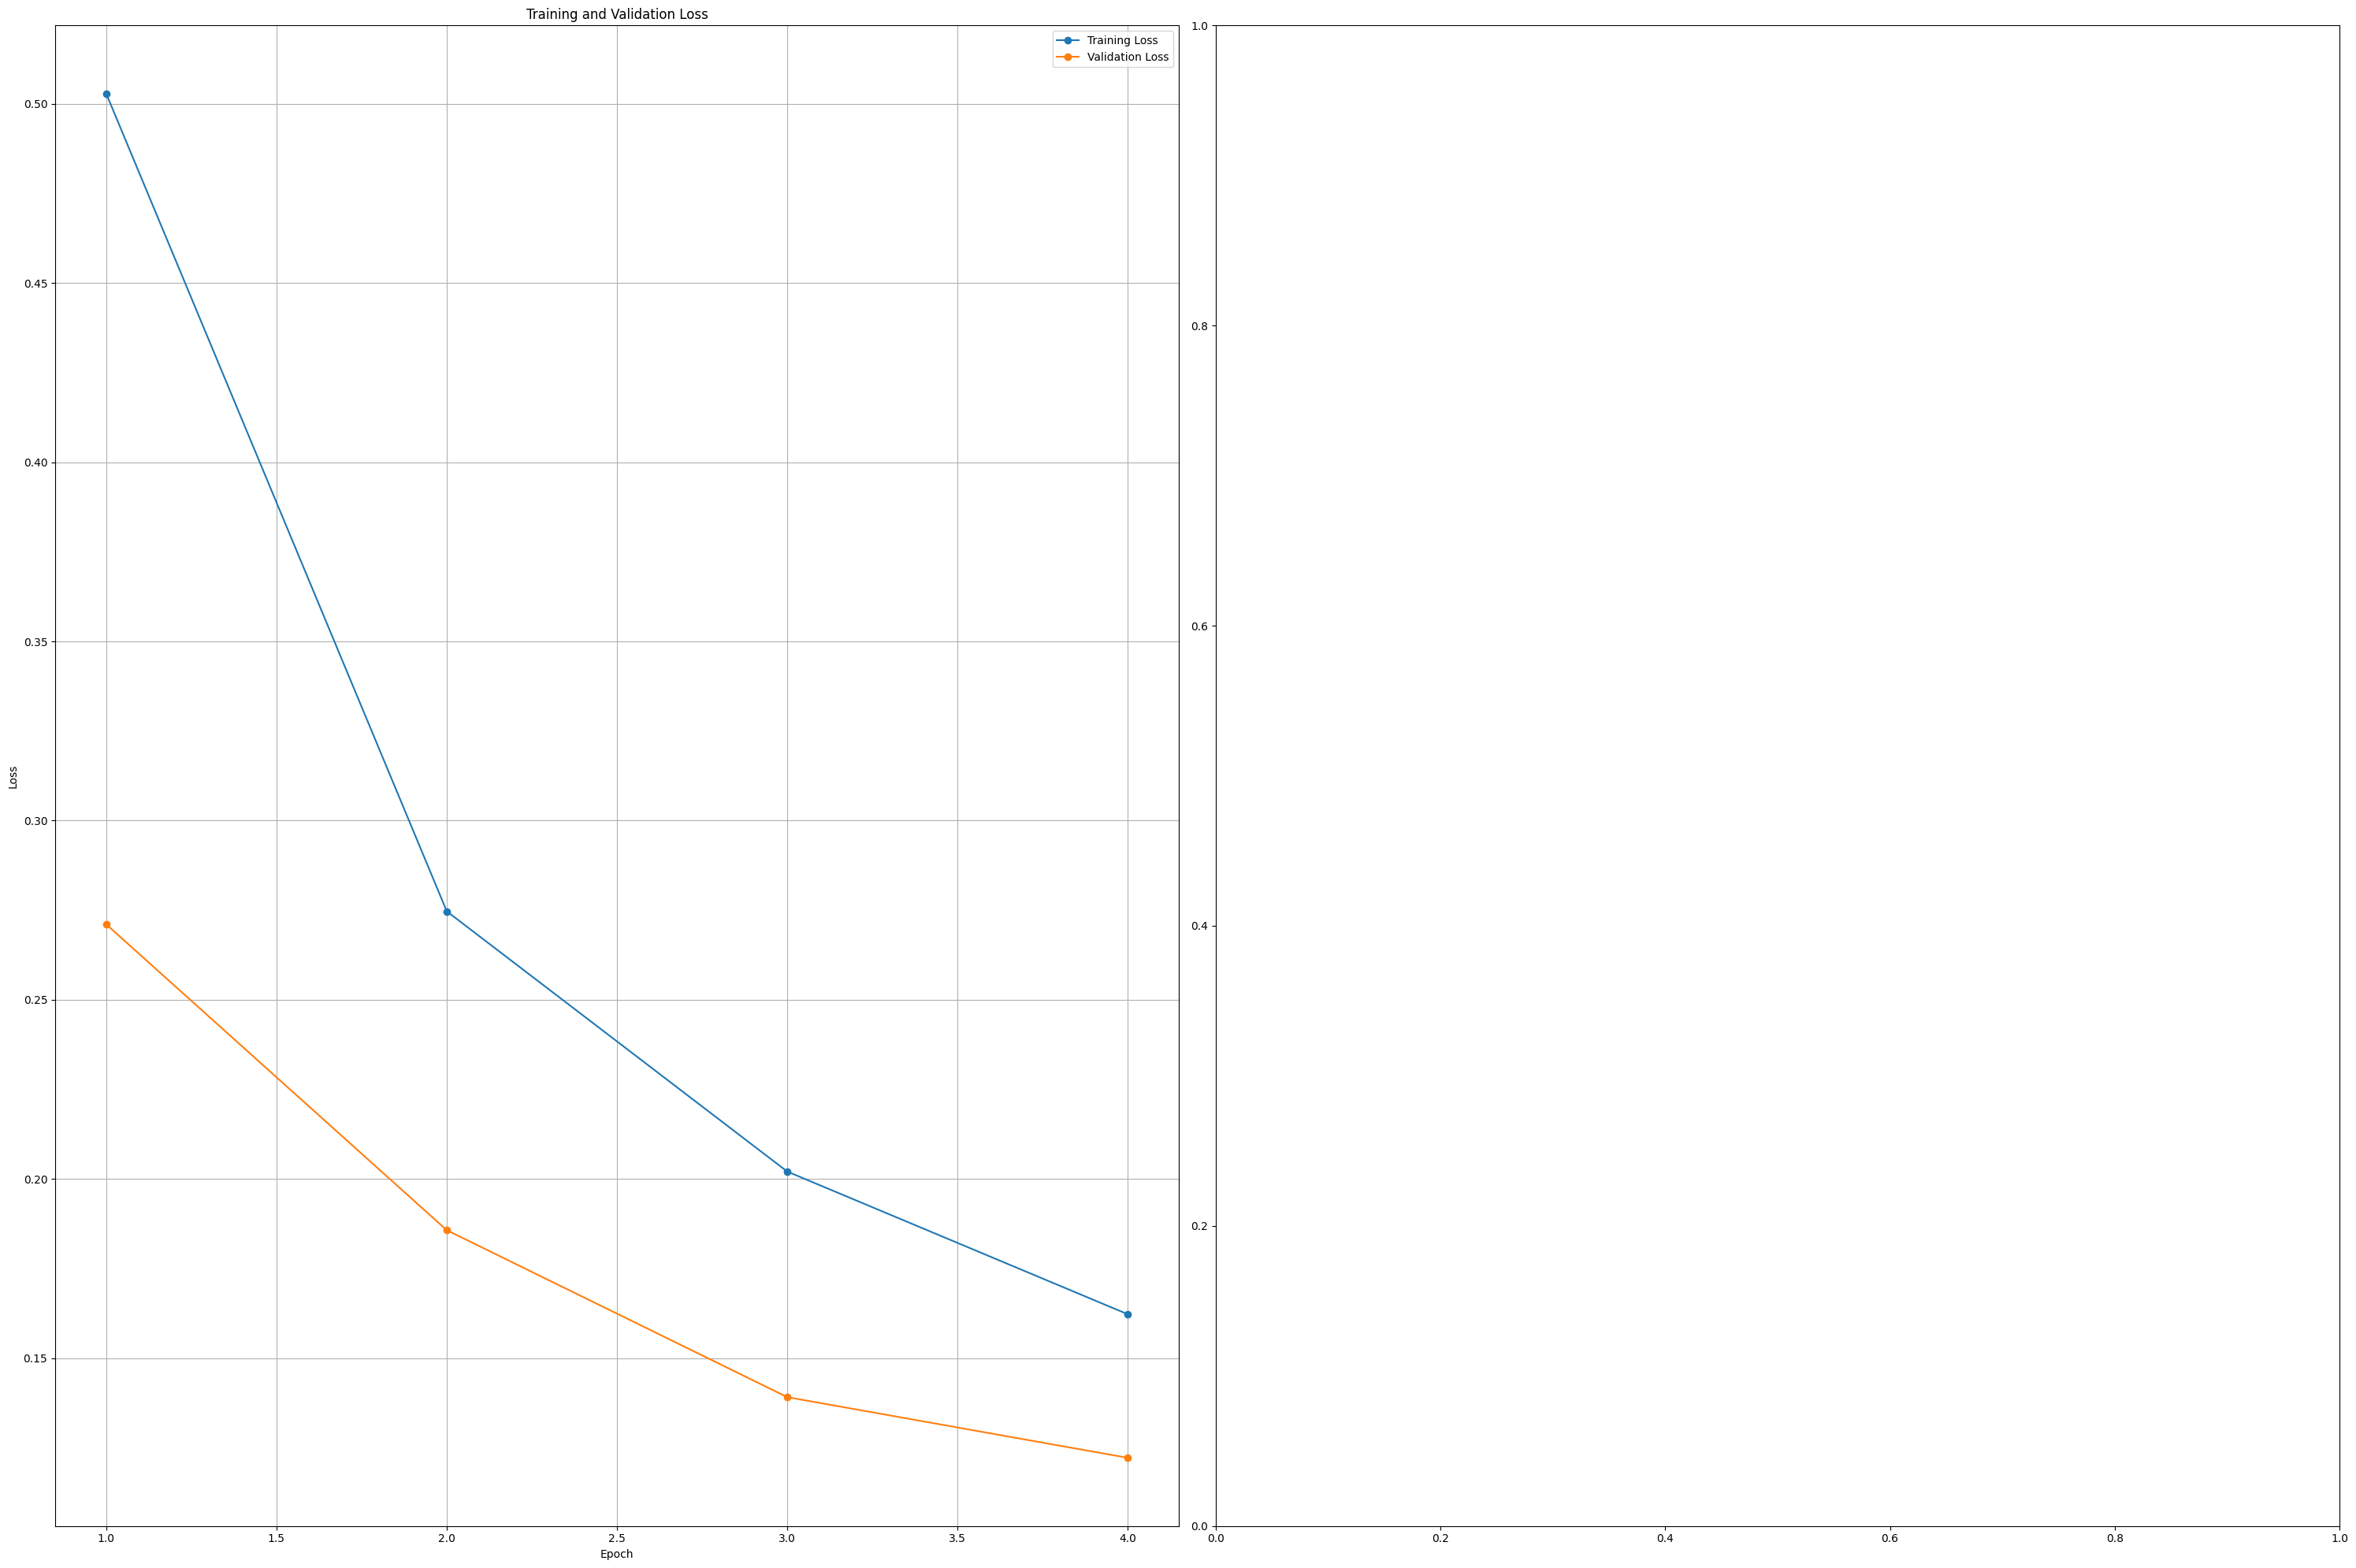

In [228]:
# Resultados
fig, axs = plt.subplots(1, 2, figsize=(30, 20))

# Gráfico de la pérdida
axs[0].plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o')
axs[0].plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='o')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)


plt.tight_layout()  # Ajustar el espaciado entre los subgráficos
plt.show()

## 3.Pruebas

In [232]:
# Función para generar texto con el modelo cargado
def generate_text(prompt, model, tokenizer, device, max_length=50):
    model.eval()
    inputs = tokenizer(prompt, return_tensors='pt').to(device)

    # Generar texto con el modelo
    outputs = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_new_tokens=max_length)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_text=generated_text.replace(prompt,',1')
    return generated_text

text="hola, quisiera solicitar una cotización para el servicio de catering?"
generated_response_2 = generate_text(text, model, tokenizer, device)
generated_response_2

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


',1 muchas gracias, eduardo lópez'

## 4.Interfaz  Básica(app.py)

In [219]:
'''

import streamlit as st
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch


# Cargar el modelo y el tokenizador guardado
model = GPT2LMHeadModel.from_pretrained("gen_modelo_soportev1")
tokenizer = GPT2Tokenizer.from_pretrained("gen_tokenizerv1")


# Configuración del modelo y dispositivo (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Función para generar texto de prueba
def generate_text(prompt):
    model.eval()
    inputs = tokenizer(prompt, return_tensors='pt').to(device)

    # Generar texto con el modelo
    outputs = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_new_tokens=50)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text

# Título de la aplicación
st.title("Asistente Virtual de Soporte al Cliente")

# Ingreso de texto por parte del usuario
user_input = st.text_input("¿Cómo puedo ayudarte hoy?", "")

# Mostrar la respuesta generada cuando el usuario ingresa una pregunta
if user_input:
    generated_response = generate_text(user_input)
    st.write(f"**Respuesta generada:** {generated_response}")


'''

'\n\nimport streamlit as st\nfrom transformers import GPT2Tokenizer, GPT2LMHeadModel\nimport torch\n\n\n# Cargar el modelo y el tokenizador guardado\nmodel = GPT2LMHeadModel.from_pretrained("gen_modelo_soportev1")\ntokenizer = GPT2Tokenizer.from_pretrained("gen_tokenizerv1")\n\n\n# Configuración del modelo y dispositivo (GPU o CPU)\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nmodel.to(device)\n\n# Función para generar texto de prueba\ndef generate_text(prompt):\n    model.eval()\n    inputs = tokenizer(prompt, return_tensors=\'pt\').to(device)\n\n    # Generar texto con el modelo\n    outputs = model.generate(inputs[\'input_ids\'], attention_mask=inputs[\'attention_mask\'], max_new_tokens=50)\n    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)\n    return generated_text\n\n# Título de la aplicación\nst.title("Asistente Virtual de Soporte al Cliente")\n\n# Ingreso de texto por parte del usuario\nuser_input = st.text_input("¿Cómo puedo 

## 5. Ejecucion de interfaz mínima

In [239]:
!streamlit run app.py

UnboundLocalError: cannot access local variable 'child' where it is not associated with a value

42559.46s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


## 6.Publicacion

## Comandos

#ingresar#############################
huggingface-cli login

#CrearRepositorio para modelo#################################################
huggingface-cli repo create gen_modelo_soportev1 --type=model
cd gen_modelo_soportev1
git init
git lfs install
git remote add origin https://huggingface.co/vmontaluisa/gen_modelo_soportev1
git add .
git lfs track "*.*"  
git commit -m "Initial commit gen_modelo_soportev1"
git push origin master


#enlace de punlicacacion modelo
https://huggingface.co/your-username/gen_modelo_soportev1/'



#Crear repositorio para dataset##################################

cd dataset
git lfs install
git init
git remote add origin https://huggingface.co/datasets/vmontaluisa/dataset_gen_modelo_soportev1
git pull origin main
git lfs track "*.json"   # Ejemplo para rastrear archivos JSON grandes
git lfs track "test/*"
git lfs track "train/*"
git add .
git push origin master


#Para actualizar Repositorio
cd dataset
git status
git add .


git push origin master

#enlace de publicacion dataset
https://huggingface.co/datasets/vmontaluisa/dataset_gen_modelo_soportev1





## EL TAMANO DEL ARCHIVO NO ME PERMITIO SUBIR 

victormontaluisa@EPSILON gen_modelo_soportev1 % git push -f origin master                                     
Uploading LFS objects: 100% (4/4), 498 MB | 5.3 MB/s, done.                                                                                                                                                      
Enumerando objetos: 11, listo.
Contando objetos: 100% (11/11), listo.
Compresión delta usando hasta 16 hilos
Comprimiendo objetos: 100% (11/11), listo.
Escribiendo objetos: 100% (11/11), 440.15 MiB | 1.92 MiB/s, listo.
Total 11 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
remote: -------------------------------------------------------------------------
remote: Your push was rejected because it contains files larger than 10 MiB.
remote: Please use https://git-lfs.github.com/ to store large files.
remote: See also: https://hf.co/docs/hub/repositories-getting-started#terminal
remote: 
remote: Offending files:
remote:   - model.safetensors (ref: refs/heads/master)
remote: -------------------------------------------------------------------------
To https://huggingface.co/vmontaluisa/gen_modelo_soportev1
 ! [remote rejected] master -> master (pre-receive hook declined)
error: falló el empuje de algunas referencias a 'https://huggingface.co/vmontaluisa/gen_modelo_soportev1'